In [1]:
import pandas as pd
pd.options.display.float_format = '{:.3f}'.format
pd.set_option("display.max_rows", None)  # 모든 행 출력
pd.set_option("display.max_columns", None)  # 모든 열 출력
import numpy as np
import matplotlib.pyplot as plt
import gurobipy as gp
from gurobipy import GRB
import os
from itertools import product
from functions import (load_parameters, load_generation_data, load_price_data, generate_randomized_generation,
generate_rt_scenarios, plot_generation_data, plot_randomized_generation, plot_scenarios_for_generator, plot_rt_scenarios, plot_summary)

generation_data, I, T = load_generation_data(date_filter="2022-07-18")
S, R, P_RT, K, K0, M1, M2 = load_parameters(I, T, generation_data)
P_DA, P_PN = load_price_data()

✅ 총 5개 파일을 불러왔습니다: 1201.csv, 137.csv, 401.csv, 524.csv, 89.csv
📊 데이터 Shape: I=5, T=24, S=20
✅ 시뮬레이션 초기화 완료: S=20, Randomness='high', M1=757.00, M2=2111.00


In [6]:
set = gp.Model("set")
set.setParam("MIPGap", 1e-7)

x = set.addVars(I, T, vtype=GRB.CONTINUOUS, lb=0, name="x")
ep = set.addVars(I, T, S, vtype=GRB.CONTINUOUS, name="e_plus")
em = set.addVars(I, T, S, vtype=GRB.CONTINUOUS, name="e_minus")

yp = set.addVars(I, T, S, vtype=GRB.CONTINUOUS, lb=0, name="y_plus")
ym = set.addVars(I, T, S, vtype=GRB.CONTINUOUS, lb=0, name="y_minus")
z = set.addVars(I, T + 1, S, vtype=GRB.CONTINUOUS, name="z")
zc = set.addVars(I, T, S, vtype=GRB.CONTINUOUS, name="z_charge")
zd = set.addVars(I, T, S, vtype=GRB.CONTINUOUS, name="z_discharge")
d = set.addVars(I, I, T, S, vtype=GRB.CONTINUOUS, lb=0, name="d")

p1 = set.addVars(I, T, S, vtype=GRB.BINARY, name="p1")
p2 = set.addVars(I, T, S, vtype=GRB.BINARY, name="p2")
p3 = set.addVars(I, T, S, vtype=GRB.BINARY, name="p3")
p4 = set.addVars(I, T, S, vtype=GRB.BINARY, name="p4")

set.update()

obj = gp.quicksum(P_DA[t] * gp.quicksum(x[i, t] for i in range(I)) for t in range(T)) + gp.quicksum((1 / S) * (P_RT[t, s] * gp.quicksum(ep[i, t, s] for i in range(I)) - P_PN[t] * gp.quicksum(em[i, t, s] for i in range(I))) for t in range(T) for s in range(S))

set.setObjective(obj, GRB.MAXIMIZE)

for i, t, s in product(range(I), range(T), range(S)):
    set.addConstr(R[i, t, s] - x[i, t] == yp[i, t, s] - ym[i, t, s] + zc[i, t, s] - zd[i, t, s])
    set.addConstr(yp[i, t, s] <= R[i, t, s])
    set.addConstr(zd[i, t, s] <= z[i, t, s])
    set.addConstr(zc[i, t, s] <= K[i] - z[i, t, s])
    set.addConstr(yp[i, t, s] <= M1 * p3[i, t, s])
    set.addConstr(ym[i, t, s] <= M1 * (1 - p3[i, t, s]))
    set.addConstr(ym[i, t, s] <= M1 * p2[i, t, s])
    set.addConstr(zc[i, t, s] <= M1 * (1 - p2[i, t, s]))
    set.addConstr(zc[i, t, s] <= M1 * p1[i, t, s])
    set.addConstr(zd[i, t, s] <= M1 * (1 - p1[i, t, s]))
    set.addConstr(z[i, t, s] <= K[i])
    set.addConstr(z[i, t + 1, s] == z[i, t, s] + zc[i, t, s] - zd[i, t, s])
for i, s in product(range(I), range(S)):
    set.addConstr(z[i, 0, s] == K0[i])

for i, t, s in product(range(I), range(T), range(S)):
    set.addConstr(ep[i, t, s] == yp[i, t, s] - gp.quicksum(d[i, j, t, s] for j in range(I)))
    set.addConstr(em[i, t, s] == ym[i, t, s] - gp.quicksum(d[j, i, t, s] for j in range(I)))
    set.addConstr(gp.quicksum(ep[i, t, s] for i in range(I)) <= M2 * p4[i, t, s])
    set.addConstr(gp.quicksum(em[i, t, s] for i in range(I)) <= M2 * (1 - p4[i, t, s]))
    set.addConstr(d[i, i, t, s] == 0)

set.optimize()

if set.status == GRB.OPTIMAL:
    print(f"Optimal solution found! Objective value: {set.objVal}")
else:
    print("No optimal solution found.")
    
x_vals = np.array([[x[i, t].X for t in range(T)] for i in range(I)])
yp_vals = np.array([[[yp[i, t, s].X for s in range(S)] for t in range(T)] for i in range(I)]) 
ym_vals = np.array([[[ym[i, t, s].X for s in range(S)] for t in range(T)] for i in range(I)])
z_vals  = np.array([[[z[i, t, s].X for s in range(S)] for t in range(T)] for i in range(I)])
zc_vals = np.array([[[zc[i, t, s].X for s in range(S)] for t in range(T)] for i in range(I)])
zd_vals = np.array([[[zd[i, t, s].X for s in range(S)] for t in range(T)] for i in range(I)])
ep_vals = np.array([[[ep[i, t, s].X for s in range(S)] for t in range(T)] for i in range(I)]) 
em_vals = np.array([[[em[i, t, s].X for s in range(S)] for t in range(T)] for i in range(I)])
d_vals = np.array([[[[d[i, j, t, s].x for s in range(S)] for t in range(T)] for j in range(I)] for i in range(I)])

Set parameter MIPGap to value 1e-07
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (mac64[arm] - Darwin 24.4.0 24E263)

CPU model: Apple M3
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
MIPGap  1e-07

Optimize a model with 40900 rows, 38620 columns and 129700 nonzeros
Model fingerprint: 0xa8c661ba
Variable types: 29020 continuous, 9600 integer (9600 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+03]
  Objective range  [2e+00, 2e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+03]
Presolve removed 21658 rows and 17000 columns
Presolve time: 0.18s
Presolved: 19242 rows, 21620 columns, 61367 nonzeros
Variable types: 16483 continuous, 5137 integer (5137 binary)
Found heuristic solution: objective 964325.94506
Found heuristic solution: objective 1062899.2673

Root relaxation: objective 1.630378e+06, 20092 iterations, 0.50 seconds (0.59 work units)

    Nodes    |    Current Node    |     Objective Bo

In [21]:
header = (
        f"{'s':>2} {'t':>2} {'i':>2} | "
        f"{'R':>8} {'x':>8} {'y+':>8} {'y-':>8} {'zc':>8} {'zd':>8} {'z':>8}\n"
        f"{'':>11}{'d_ijt':>8} {'d_jit':>8} {'':>8} {'':>8}\n"
        f"{'':>11}{'':>8} {'':>8} {'e+':>8} {'e-':>8}\n"
        + "-" * 80
    )
print(header)

for s, t, i in product(range(S), range(T), range(I)):
        R_val = R[i, t, s]
        x_val = x_vals[i, t]
        yp_val = yp_vals[i, t, s]
        ym_val = ym_vals[i, t, s]
        zc_val = zc_vals[i, t, s]
        zd_val = zd_vals[i, t, s]
        z_val = z_vals[i, t, s]
        ep_val = ep_vals[i, t, s]
        em_val = em_vals[i, t, s]
        d_ijt = sum(d_vals[i, j, t, s] for j in range(I) if j != i)
        d_jit = sum(d_vals[j, i, t, s] for j in range(I) if j != i)

        print(
            f"{s:>2} {t:>2} {i:>2} | "
            f"{R_val:>8.2f} {x_val:>8.2f} {yp_val:>8.2f} {ym_val:>8.2f} "
            f"{zc_val:>8.2f} {zd_val:>8.2f} {z_val:>8.2f}"
        )
        print(
            f"{'':>11}{d_ijt:>8.2f} {d_jit:>8.2f} {' ':>8} {' ':>8} \n"
            f"{'':>11}{' ':>8} {' ':>8} {ep_val:>8.2f} {em_val:>8.2f}"
        )

 s  t  i |        R        x       y+       y-       zc       zd        z
              d_ijt    d_jit                  
                                   e+       e-
--------------------------------------------------------------------------------
 0  0  0 |     0.00     0.00     0.00     0.00     0.00     0.00     0.00
               0.00     0.00                   
                                 0.00     0.00
 0  0  1 |     0.00     0.00     0.00     0.00     0.00     0.00     0.00
               0.00     0.00                   
                                 0.00     0.00
 0  0  2 |     0.00     0.00     0.00     0.00     0.00     0.00     0.00
               0.00     0.00                   
                                 0.00     0.00
 0  0  3 |     0.00     0.00     0.00     0.00     0.00     0.00     0.00
               0.00     0.00                   
                                 0.00     0.00
 0  0  4 |     0.00     0.00     0.00     0.00     0.00     0.00     0.00
 

In [3]:
da_profit = sum(P_DA[t] * x[i, t].X for i in range(I) for t in range(T))
rt_profit = sum(P_RT[t, s] * ep[i, t, s].X / S for i in range(I) for t in range(T) for s in range(S))
pn_cost   = sum(P_PN[t] * em[i, t, s].X / S for i in range(I) for t in range(T) for s in range(S))
total_profit = da_profit + rt_profit - pn_cost

print("[SETTLEMENT MODEL]")
print(f"DA Profit      = {da_profit:.2f}")
print(f"RT Profit      = {rt_profit:.2f}")
print(f"Penalty Cost   = {pn_cost:.2f}")
print(f"Total Profit   = {total_profit:.2f}")

[SETTLEMENT MODEL]
DA Profit      = 520114.28
RT Profit      = 1122995.05
Penalty Cost   = 13839.57
Total Profit   = 1629269.77



[SETTLEMENT MODEL] Day-Ahead Commitment (sum over DERs):
TOTAL: 3322.00


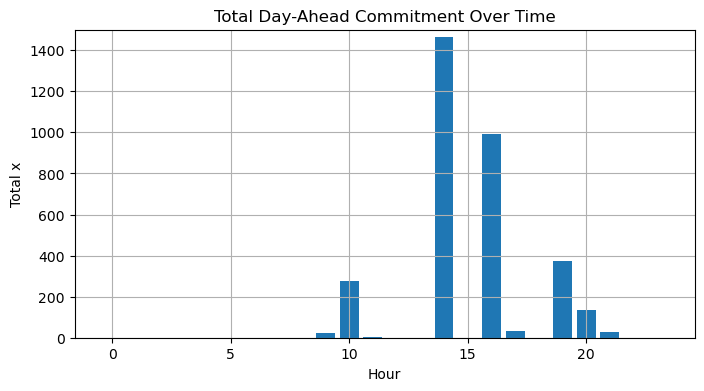

In [4]:
print("\n[SETTLEMENT MODEL] Day-Ahead Commitment (sum over DERs):")
total_only_commit = 0
for t in range(T):
    commit_t = sum(x[i, t].X for i in range(I))
    total_only_commit += commit_t
    # print(f"Time {t}: {commit_t:.2f}")
print(f"TOTAL: {total_only_commit:.2f}")

plt.figure(figsize=(8, 4))
plt.bar(range(T), x_vals.sum(axis=0))
plt.title("Total Day-Ahead Commitment Over Time")
plt.xlabel("Hour")
plt.ylabel("Total x")
plt.ylim(0,1500)
plt.grid(True)
plt.show()

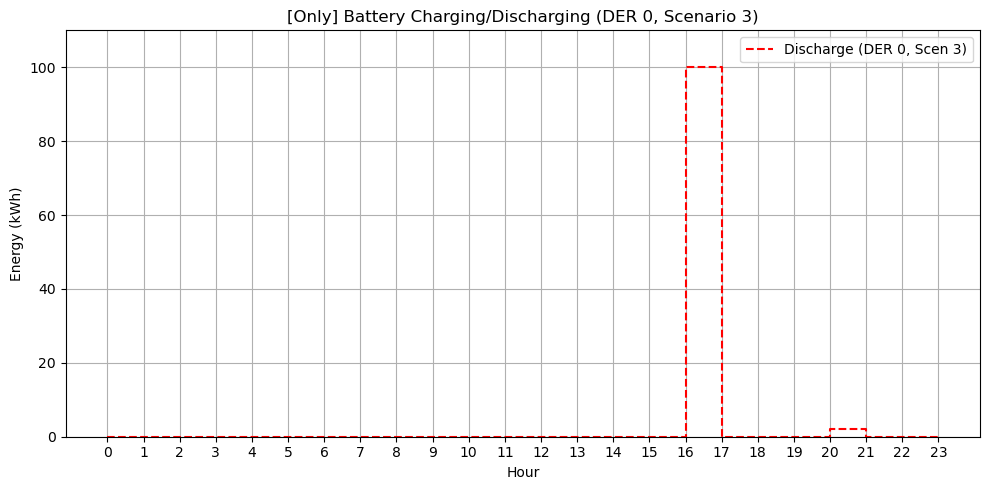

In [5]:
i=0
s=3
zc_single = zc_vals[i, :, s]  
zd_single = zd_vals[i, :, s]
z_single = z_vals[i, :, s]
hours = np.arange(len(zc_single))

plt.figure(figsize=(10, 5))
# plt.step(hours, zc_single, where='post', label=f"Charge (DER {i}, Scen {s})", color = 'green', linestyle = "--", linewidth = 1.5)
plt.step(hours, zd_single, where='post', label=f"Discharge (DER {i}, Scen {s})", linestyle = "--", color = 'red')
# plt.step(hours, z_single, where='post', label=f"SoC (DER {i}, Scen {s})", color='#00821E', linewidth=2)
plt.title(f"[Only] Battery Charging/Discharging (DER {i}, Scenario {s})")
plt.xlabel("Hour")
plt.ylabel("Energy (kWh)")
plt.ylim(0, K[i].max()+10)
plt.xticks(hours)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()